In [111]:
from gensim.models import word2vec
import matplotlib.pyplot as plt
from pyvi import ViTokenizer
import pandas as pd
import numpy as np
from tqdm import tqdm
from src.dtprocess import cleandt
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
# from google.colab import drive
# drive.mount('/content/drive')

In [59]:
# %cd /content/drive/My Drive/Colab Notebooks/Text_Generator

In [60]:
# %ls -la

## Import and normalize data

In [61]:
news = pd.read_csv('./data/vnexpress/csv/vnexpress.csv').drop(columns='Unnamed: 0', axis=1)
print(news.shape)

(2481, 6)


In [62]:
news['tag'] = news['content'] + news['title'] + news['description']
news.drop(columns=['description','content'], inplace=True)

In [63]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  2481 non-null   int64 
 1   topic       2481 non-null   object
 2   sub-topic   2481 non-null   object
 3   title       2479 non-null   object
 4   tag         2418 non-null   object
dtypes: int64(1), object(4)
memory usage: 97.0+ KB


In [64]:
news.isna().sum()

article_id     0
topic          0
sub-topic      0
title          2
tag           63
dtype: int64

In [65]:
news.dropna(axis=0, inplace=True)
news.reset_index(inplace=True)

In [66]:
news['tag'] = news['tag'].apply(lambda x: x.lower())
news['tag'] = news['tag'].apply(lambda x: cleandt.remove_punctuation(x))
news['tag'] = news['tag'].apply(ViTokenizer.tokenize)
news['tag'] = news['tag'].apply(lambda x: cleandt.remove_stopword(x, './data/vietnamese-stopwords-dash.txt'))

In [67]:
print(news['topic'].value_counts())
news

topic
giai-tri    614
the-thao    498
khoa-hoc    410
doi-song    361
giao-duc    355
du-lich     180
Name: count, dtype: int64


index  article_id     topic    sub-topic  \
0         0           0  doi-song        to-am   
1         1           1  doi-song        to-am   
2         2           2  doi-song        to-am   
3         3           3  doi-song        to-am   
4         4           4  doi-song        to-am   
...     ...         ...       ...          ...   
2413   2476        2476  the-thao  tuong-thuat   
2414   2477        2477  the-thao  tuong-thuat   
2415   2478        2478  the-thao  tuong-thuat   
2416   2479        2479  the-thao  tuong-thuat   
2417   2480        2480  the-thao  tuong-thuat   

                                                  title  \
0                              Có nên bắt trẻ xin lỗi?    
1                 Tác dụng bất ngờ của việc gọi cho mẹ    
2     Thiệt thòi của trẻ 'nửa tuần ở với bố, nửa tuầ...   
3         Bi kịch ở tuổi 50 của người phụ nữ Hậu Giang    
4                                Sốc văn hóa nhà chồng    
...                                                 ...   
2413      Việt Nam thua trận đậm nhất World Cup nữ 2023   
2414    Việt Nam hết hy vọng qua vòng bảng World Cup nữ   
2415       Việt Nam thua Mỹ ở trận ra quân World Cup nữ   
2416                         World Cup nữ 2023 khai mạc   
2417          Alcaraz hạ Djokovic ở chung kết Wimbledon   

                                                    tag  
0     xin_lỗi đi thế_hệ câu trẻ anh_chị_em bạn_bè xô...  
1     nghiên_cứu đại_học wisconsinmadison mỹ xem_xét...  
2     yếu_tố độ trẻ quan_hệ cha_mẹ hai mức_độ xung_đ...  
3     đôi_mươi trần thị liên_kết_hôn lâm_sơn hải ấp ...  
4     hoàng thị hòa 34 hà nam chồng học 3 km bố_mẹ h...  
...                                                 ...  
2413  ghi_bàn martens 8 snoeijs 11 brugts 18 57 roor...  
2414  ghi_bàn encarnacao 7 nazareth 21 trận bồ đào n...  
2415  ghi_bàn smith 14 45 horan 77 đối_thủ thế_giới ...  
2416  cầu_thủ hai đội khởi_động xong ban tổ_chức tắt...  
2417  alcaraz mở_màn game giao_bóng quyết_định cú hỏ...  

[2418 rows x 6 columns]

## Create word embedding model from Word2Vec

In [68]:
sequences = news['tag'].to_list()
input_gensim = []

for sen in sequences:
  input_gensim.append(sen.split())

In [69]:
model = word2vec.Word2Vec(input_gensim, vector_size=128, window=5, min_count=0, workers=4, sg=1)
model.save("./model/word.model")

In [70]:
model = word2vec.Word2Vec.load("./model/word.model")

## Find similar texts by Cosine measure

In [140]:
question = '''
Với CLB Hà Lan, tiền đạo cánh người Brazil đạt tỷ lệ ghi bàn và kiến tạo kỳ vọng là 0,58, chỉ xếp thứ 14 nếu đặt ở Ngoại hạng Anh. Ngoài ra, Antony cũng được "thổi phồng" nhờ chơi cho CLB vượt trội về tài chính và lực lượng so với phần còn lại của giải vô địch Hà Lan.
'''

In [141]:
def embedding(question, input_gensim, length):
  question_tokens = cleandt.remove_punctuation(question)
  question_tokens = ViTokenizer.tokenize(question_tokens)
  question_tokens = cleandt.remove_stopword(question_tokens, './data/vietnamese-stopwords-dash.txt')
  print('After tonkenized:', question_tokens)
  
  # Word embeddings
  question_embeddings = [model.wv[word] for word in question_tokens.split() if word in model.wv]

  # Post embeddings
  post_check = input_gensim[:length]

  post_embeddings = []
  for post in post_check:
    post_embedding = [model.wv[word] for word in post if word in model.wv]
    post_embeddings.append(post_embedding)

  return question_embeddings, post_embeddings

question_embeddings, post_embeddings = embedding(question, input_gensim, len(input_gensim))

After tonkenized: Với CLB Hà_Lan tiền_đạo cánh Brazil tỷ_lệ ghi_bàn kiến_tạo kỳ_vọng 058 xếp 14 Ngoại_hạng Anh Ngoài_ra Antony thổi_phồng CLB vượt_trội tài_chính lực_lượng giải vô_địch Hà_Lan


In [142]:
print(len(question_embeddings))
question_embeddings[0]

14


array([ 0.32221526, -0.24294023, -0.09745548, -0.13783075,  0.16068271,
       -0.26846766,  0.22800851, -0.17231998, -0.39585692,  0.5041406 ,
        0.10499745, -0.39853716, -0.18343581,  0.2128257 ,  0.06390679,
       -0.35071194, -0.37859702,  0.16856118, -0.00327418, -0.06105788,
        0.36354968, -0.09833966,  0.35767967,  0.21113725, -0.13154764,
        0.4206381 , -0.28591806,  0.62560904,  0.18088755, -0.49436083,
       -0.6171209 ,  0.5616397 , -0.0097766 ,  0.4810187 , -0.1232376 ,
       -0.32196605,  0.04865083,  0.19672126, -0.1387715 , -0.2462126 ,
       -0.17813626, -0.24537896, -0.80057734, -0.5518355 ,  0.05903726,
        0.4556891 , -0.68798923, -0.18094128,  0.43903902,  0.6841393 ,
       -0.00866732,  0.12573124, -0.05307845,  0.46335205, -0.57491124,
        0.6287083 , -0.591304  ,  0.07454038, -0.01049291, -0.13610941,
        0.05734543,  0.69847023, -0.00458654, -0.40452   ,  0.1366213 ,
       -0.10416292, -0.5912275 , -0.14606051,  0.27981868, -0.46

In [144]:
from sklearn.metrics.pairwise import cosine_similarity

In [149]:
# Calculate sentence embeddings by averaging word embeddings
def mean_vector_embedding(embeddings):
  if len(embeddings) == 0:
      return np.zeros(model.vector_size)
  return np.mean(embeddings, axis=0)

mean_sentence_embedding = mean_vector_embedding(question_embeddings)
print('The len of the mean embedding vector:', len(mean_sentence_embedding))

def mean_embedded_posts(post_embeddings):
  mean_post_embedding = []
  for post_embedding in post_embeddings:
      mean_post_embedding.append(mean_vector_embedding(post_embedding))

  return mean_post_embedding

mean_post_embedding = mean_embedded_posts(post_embeddings)
print('The length of the mean embedding posts:', len(mean_post_embedding))

# Calculate similarity (cosine similarity)
similarity_score = cosine_similarity([mean_sentence_embedding], mean_post_embedding)

# Print the similarity score
print(f"Similarity Score: {similarity_score}")

The len of the mean embedding vector: 128
The length of the mean embedding posts: 2418
Similarity Score: [[0.69646144 0.68978405 0.70317864 ... 0.9175289  0.8755066  0.90611345]]


In [146]:
# Convert the list of lists into a numpy array
np_similarity_score = np.array(similarity_score)
print('np_question_embedding', np_similarity_score)
# Sort the array in ascending order
sorted_indices = np.argsort(np_similarity_score[0])[::-1]

# Get the top 5 indices
top_5_indices = sorted_indices[:5]

# Print the sorted indices and the top 5 indices
print("Sorted Indices:", sorted_indices)
print("Top 5 Indices:", top_5_indices)

np_question_embedding [[0.69646144 0.68978405 0.70317864 ... 0.9175289  0.8755066  0.90611345]]
Sorted Indices: [2285 1975 1976 ... 1335 1361 1870]
Top 5 Indices: [2285 1975 1976 1933 2304]


In [147]:
news.loc[top_5_indices, :]

index  article_id     topic   sub-topic  \
2285   2344        2344  the-thao       photo   
1975   2026        2026  the-thao  bundesliga   
1976   2027        2027  the-thao  bundesliga   
1933   1984        1984  the-thao  bundesliga   
2304   2365        2365  the-thao       photo   

                                                  title  \
2285     10 ngôi sao đẳng cấp thế giới ở Asian Cup 2023   
1975     15 HLV gây ấn tượng nhất nửa đầu mùa 2023-2024   
1976  15 hợp đồng thành công nhất nửa đầu mùa 2023-2024   
1933      Kane chạm tay vào Giày vàng châu Âu đầu tiên    
2304              Những nhân tố đang vụt sáng ở châu Âu   

                                                    tag  
2285  almoez ali qatar nhân_tố giúp qatar vô_địch as...  
1975  15 pep guardiola man city cú mùa 20222023 guar...  
1976  15 sergino dest psv mượn barca hậu_vệ trái des...  
1933  tuần kane lập hattrick trận bayern thắng mainz...  
2304  serhou guirassy áo trắng hiện_tượng dẫn_đầu da...

## Visualize the relationships

* The relationships among words

In [78]:
from sklearn.decomposition import PCA

In [79]:
def words_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [word for word in model.wv.vocab]
        
    word_vectors = np.array([model.wv[w] for w in words])
    
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y-0.10, word)

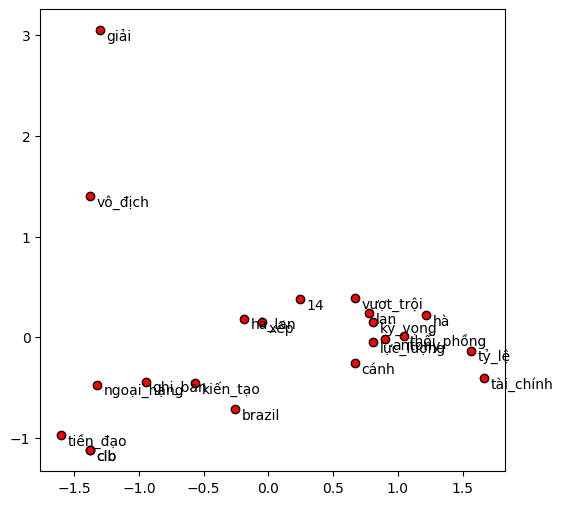

In [80]:
sentence = '''Với CLB Hà Lan tiền đạo cánh người Brazil đạt tỷ lệ ghi bàn và kiến tạo kỳ vọng là chỉ xếp thứ 14 nếu đặt ở Ngoại hạng Anh. 
Ngoài ra, Antony cũng được "thổi phồng" nhờ chơi cho CLB vượt trội về tài chính và lực lượng so với phần còn lại của giải vô địch Hà Lan'''

sentence = sentence.lower()
sentence = cleandt.remove_punctuation(sentence)
sentence = ViTokenizer.tokenize(sentence)
sentence = cleandt.remove_stopword(sentence, './data/vietnamese-stopwords-dash.txt')
words = sentence.split()

words_scatterplot(model, words)

* The relationships among documents

In [81]:
_, temp_embeddings = embedding("", input_gensim, 100)
mean_temp_embedding = mean_embedded_posts(temp_embeddings)

After tonkenized: 


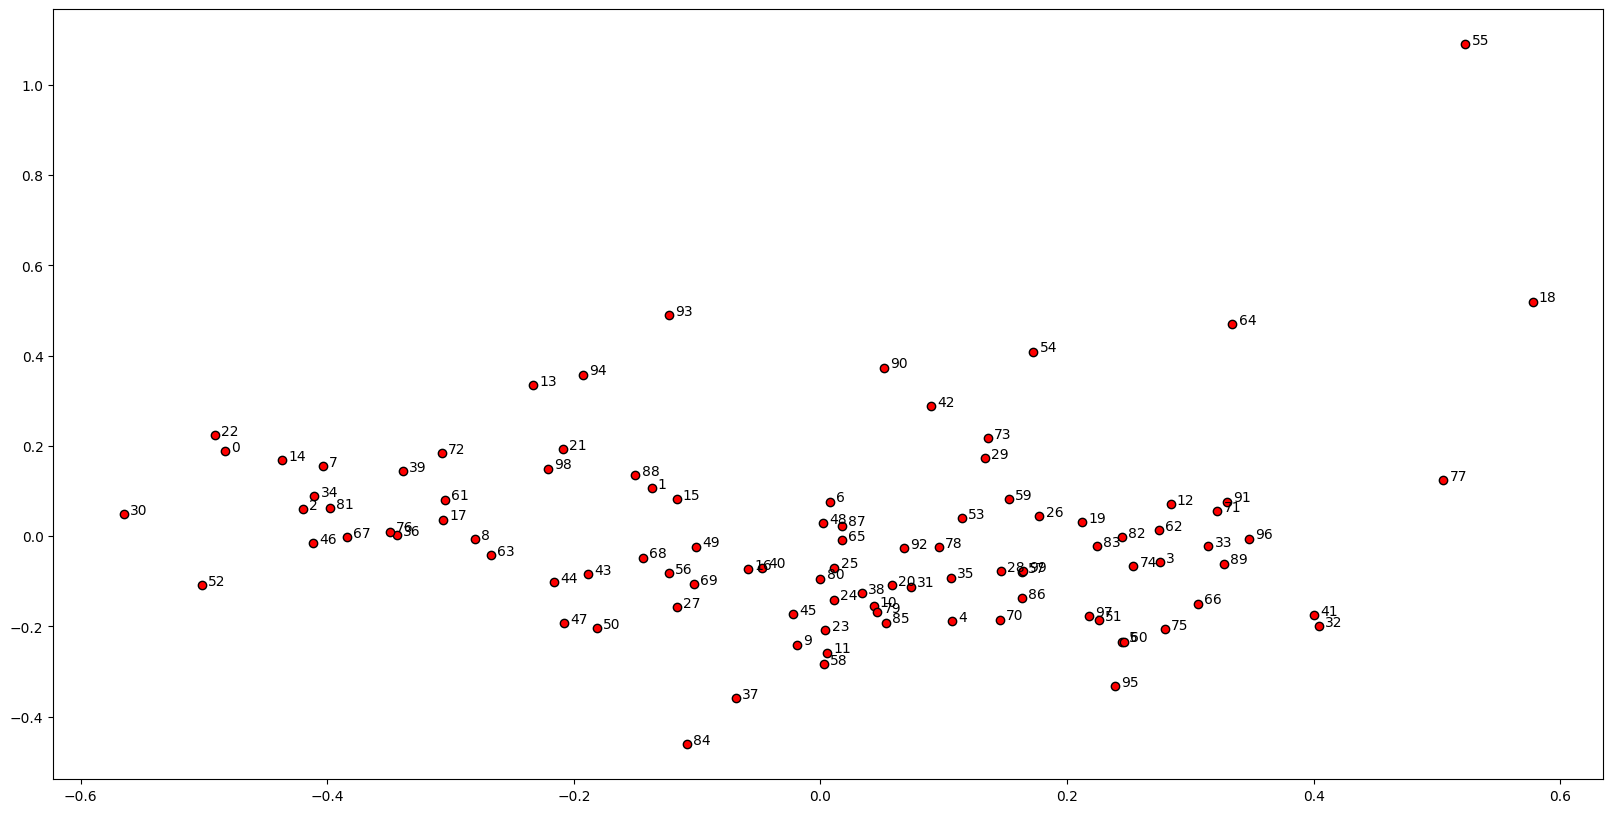

In [82]:
# mean_post_embedding
post_vectors = []
for post_embedding in mean_temp_embedding:
    post_vectors.append(post_embedding.tolist())

twodim = PCA().fit_transform(post_vectors)[:,:2]
index = [i for i,_ in enumerate(mean_temp_embedding)]

plt.figure(figsize=(20,10))
plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
for doc, (x,y) in zip(index, twodim):
    plt.text(x+0.005, y, doc)

## Text clustering with Kmean algorithm

In [83]:
text_embeddings = []
for text in input_gensim:
    text_embedding = [model.wv[word] for word in text if word in model.wv]
    text_embeddings.append(text_embedding)
    
print(len(text_embeddings))
print(len(text_embeddings[0]))

2418
304


In [84]:
# Tính vector trung bình cho từng word trong từng văn bản
mean_text_embeddings = []
for emebbed in tqdm(text_embeddings):
     temp = np.mean(emebbed, axis=1)
     mean_text_embeddings.append(list(temp))
     
print(len(mean_text_embeddings))

100%|██████████| 2418/2418 [00:00<00:00, 2580.57it/s]

2418


In [85]:
from clusteval import clusteval
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from tensorflow.keras import preprocessing

In [86]:
max_length = max([len(i) for i in mean_text_embeddings])
mean_text_embeddings_padding = np.array(preprocessing.sequence.pad_sequences(mean_text_embeddings, maxlen=max_length, padding='pre', dtype='float32'))

In [87]:
print("The shape of padding sequences array:", mean_text_embeddings_padding.shape)
print(mean_text_embeddings_padding[0:5])

The shape of padding sequences array: (2418, 1995)
[[ 0.          0.          0.         ... -0.01428613 -0.04728192
  -0.01155391]
 [ 0.          0.          0.         ... -0.0067737  -0.02587833
  -0.0193274 ]
 [ 0.          0.          0.         ... -0.02516341  0.00589586
  -0.02492141]
 [ 0.          0.          0.         ... -0.00740659 -0.02844947
  -0.02197713]
 [ 0.          0.          0.         ... -0.01391438 -0.00196861
  -0.03569172]]


In [88]:
# Set parameters, as an example dbscan
ce = clusteval(evaluate='silhouette', max_clust=20, normalize=True)

# Fit to find optimal number of clusters using dbscan
results = ce.fit(mean_text_embeddings_padding)

[clusteval] >INFO> Normalizing input data per feature (zero mean and unit variance)


[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.


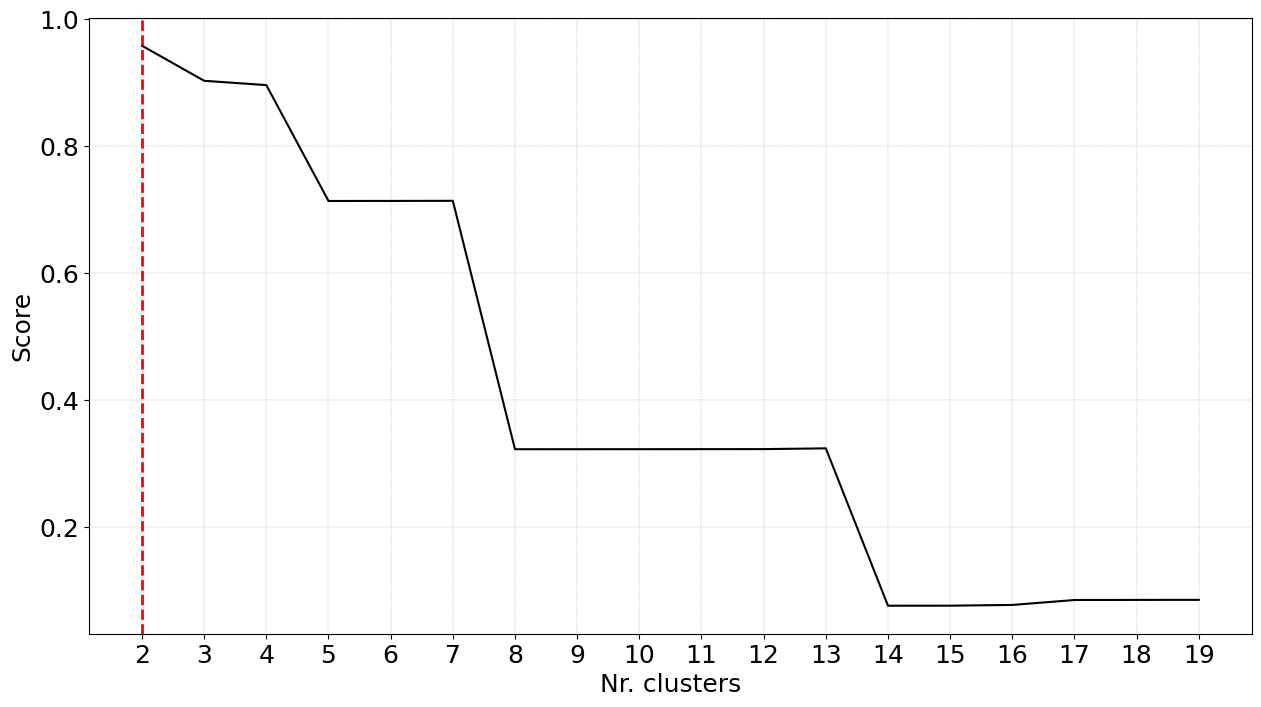

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [89]:
ce.plot(verbose=0)

Text(0, 0.5, 'Sum of squared distance')

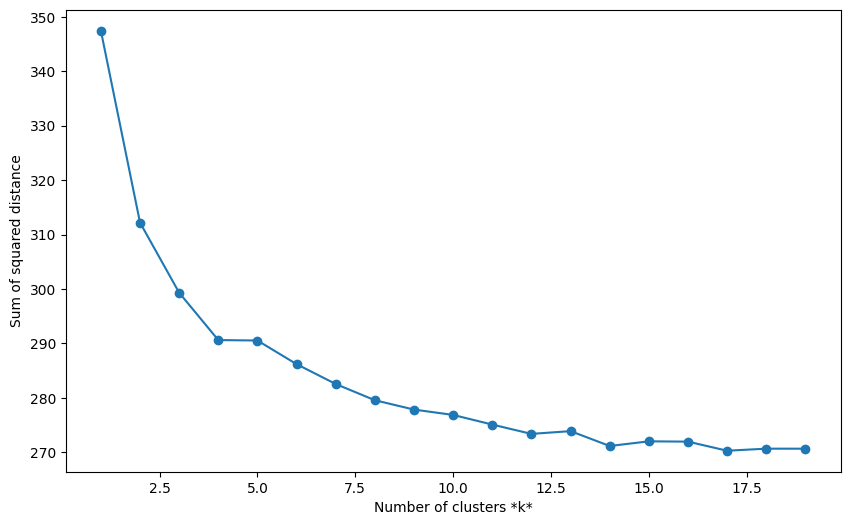

In [90]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(mean_text_embeddings_padding)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(10, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

In [134]:
kmeans = KMeans(n_clusters=4, verbose=1).fit(mean_text_embeddings_padding)
text_clustering = kmeans.predict(mean_text_embeddings_padding)

Initialization complete
Iteration 0, inertia 495.6134948730469.
Iteration 1, inertia 297.4239501953125.
Iteration 2, inertia 292.71185302734375.
Iteration 3, inertia 291.35870361328125.
Iteration 4, inertia 290.8957824707031.
Iteration 5, inertia 290.6942443847656.
Iteration 6, inertia 290.6419677734375.
Iteration 7, inertia 290.6309509277344.
Iteration 8, inertia 290.63018798828125.
Converged at iteration 8: strict convergence.


In [135]:
embedding_2d = PCA().fit_transform(mean_text_embeddings_padding)[:,:2]
temp = np.append(embedding_2d, text_clustering.reshape((len(text_clustering), 1)), axis=1)
df = pd.DataFrame(temp)

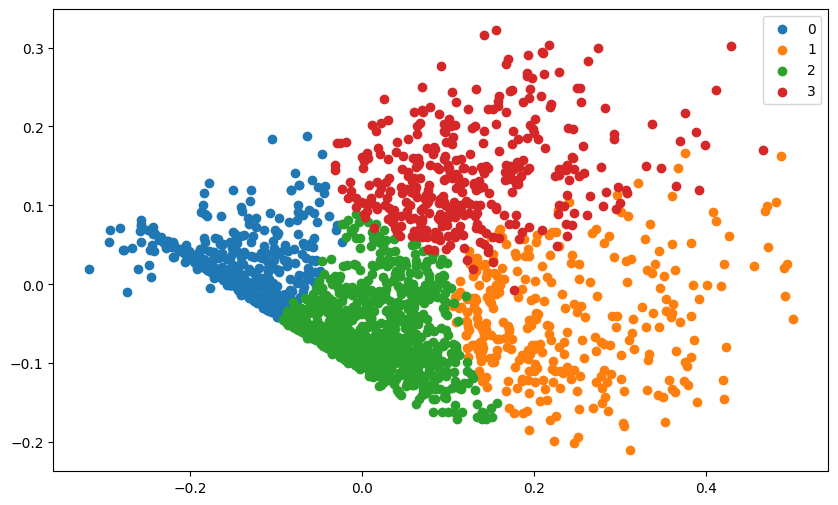

In [136]:
#Getting unique labels
u_labels = np.unique(text_clustering)

#plotting the results
plt.figure(figsize=(10, 6))
for i in u_labels:
    plt.scatter(df[df[2]==i][0] , df[df[2]==i][1], label = i)
plt.legend()
plt.show()

In [137]:
clustered_news = news.copy()
clustered_news.loc[:, len(clustered_news.columns)] = list(text_clustering)

<function matplotlib.pyplot.show(close=None, block=None)>

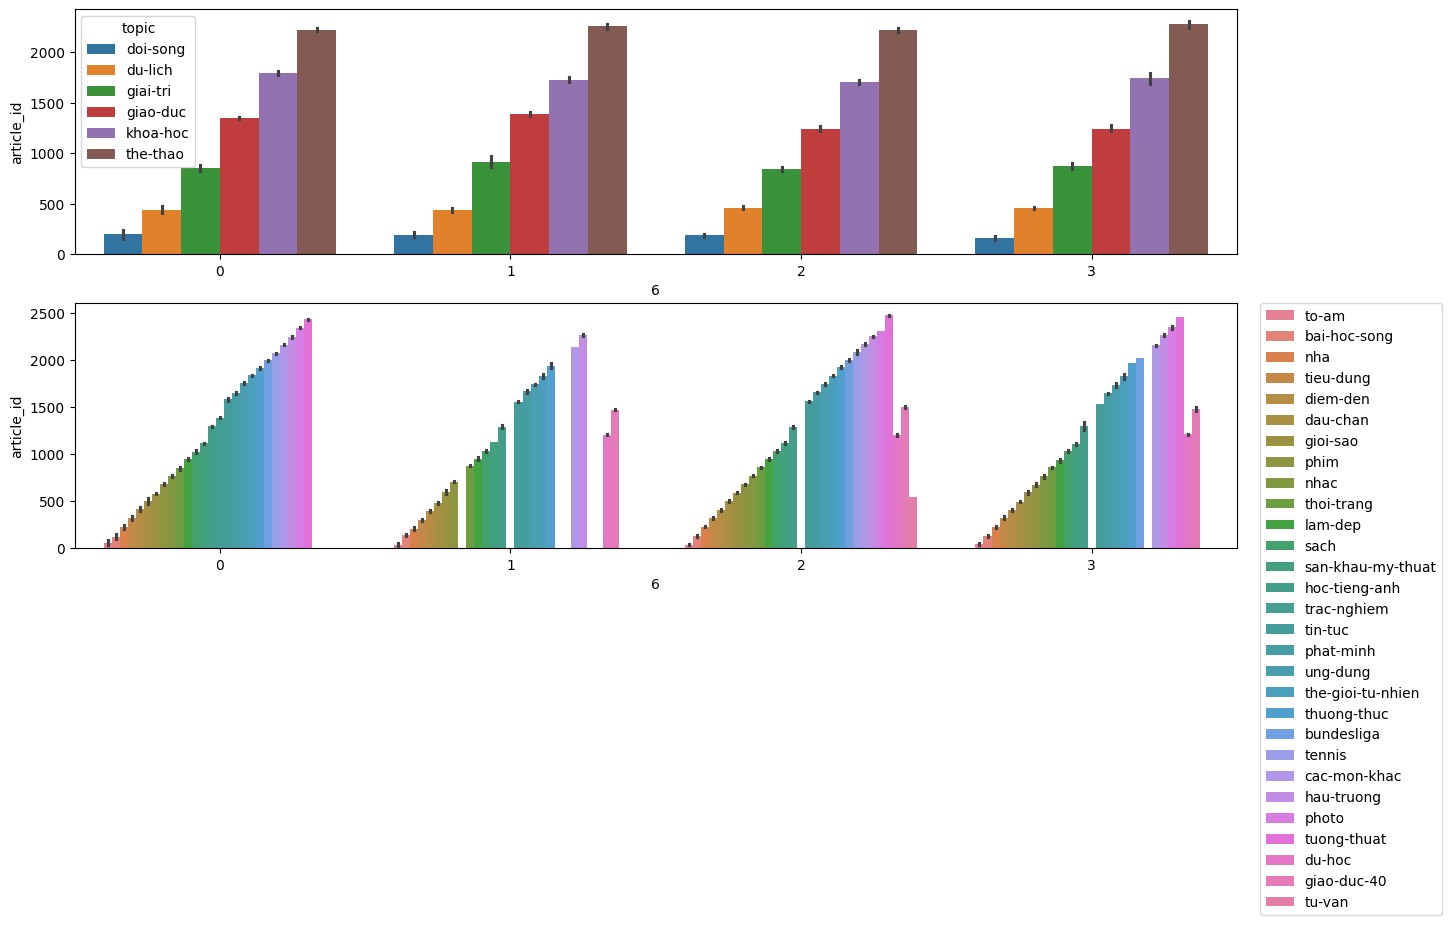

In [139]:
fig, ax = plt.subplots(2, 1, figsize=(15, 7))
sns.barplot(data=clustered_news, y="article_id", x=6, hue="topic", ax=ax[0])
sns.barplot(data=clustered_news, y="article_id", x=6, hue="sub-topic", ax=ax[1])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show